# Data Preprocessing steps
 Here, we combined all the relevant financial data (technical indicators, macro indicators, historical price data)
 into one single dataset which we could then train an LSTM model on.

In [80]:
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

def expand_monthly(file, sheet_name=None):
    # Read the file
    df = pd.read_excel(file, sheet_name=sheet_name) if file.endswith('.xlsx') else pd.read_csv(file)
    
    # Convert observation_date to datetime
    df['observation_date'] = pd.to_datetime(df['observation_date'])
    
    # Create a list to store daily data
    daily_rows = []
    
    # Iterate through each row
    for _, row in df.iterrows():
        # Get the number of days in the month
        days_in_month = row['observation_date'].days_in_month
        
        # Create daily rows for this month
        for day in range(1, days_in_month + 1):
            daily_row = row.copy()
            daily_row['observation_date'] = row['observation_date'].replace(day=day)
            daily_rows.append(daily_row)
    
    # Convert to DataFrame
    daily_df = pd.DataFrame(daily_rows)
    
    # Sort and reset index
    daily_df = daily_df.sort_values('observation_date').reset_index(drop=True)
    
    return daily_df

# Process files
liquidity = expand_monthly('m1m2.xlsx', 'Monthly')
fedIR = expand_monthly('fedIR.csv')






# Read USD strength data
usd_strength = pd.read_csv('usdstrength.csv')
usd_strength['Date'] = pd.to_datetime(usd_strength['Date'])

# Create a continuous date range
start_date = usd_strength['Date'].min()
end_date = usd_strength['Date'].max()
continuous_dates = pd.date_range(start=start_date, end=end_date, freq='D')

# Create a new dataframe with continuous dates
continuous_df = pd.DataFrame({'Date': continuous_dates})

# Merge with original data
usd_strength_continuous = continuous_df.merge(usd_strength, on='Date', how='left')

# Fill missing values
for col in ['Open', 'High', 'Low', 'Close']:
    # First, interpolate linearly
    usd_strength_continuous[col] = usd_strength_continuous[col].interpolate()

# If there are still NaNs at the start or end, use forward or backward fill
for col in ['Open', 'High', 'Low', 'Close']:
    usd_strength_continuous[col] = usd_strength_continuous[col].fillna(method='ffill').fillna(method='bfill')


C:\Users\zhang\AppData\Local\Temp\ipykernel_18412\3990247445.py:50: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  usd_strength['Date'] = pd.to_datetime(usd_strength['Date'])
C:\Users\zhang\AppData\Local\Temp\ipykernel_18412\3990247445.py:70: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  usd_strength_continuous[col] = usd_strength_continuous[col].fillna(method='ffill').fillna(method='bfill')


In [81]:
print(usd_strength_continuous.head())
print(liquidity.head())
print(fedIR.head())

        Date   Open   High    Low  Close
0 2014-12-01  88.30  88.45  87.78  87.98
1 2014-12-02  87.99  88.67  87.95  88.63
2 2014-12-03  88.61  89.00  88.58  88.96
3 2014-12-04  88.93  89.12  88.21  88.60
4 2014-12-05  88.62  89.47  88.58  89.36
  observation_date  M1SL_M2SL
0       1959-01-01    0.48465
1       1959-01-02    0.48465
2       1959-01-03    0.48465
3       1959-01-04    0.48465
4       1959-01-05    0.48465
  observation_date  FEDFUNDS
0       1954-07-01       0.8
1       1954-07-02       0.8
2       1954-07-03       0.8
3       1954-07-04       0.8
4       1954-07-05       0.8


In [82]:
# TRUNCATING DATASETS from 2015-03-02 to 2025-02-28
usd_strength_continuous = usd_strength_continuous[['Date', 'Close']]
dollar_index_selected = usd_strength_continuous[usd_strength_continuous['Date'].between('2015-03-02', '2025-01-31')]

liquidity_selected = liquidity[liquidity['observation_date'].between('2015-03-02', '2025-01-31')]

fedIR_selected = fedIR[fedIR['observation_date'].between('2015-03-02', '2025-01-31')]

print(dollar_index_selected.head())
print(liquidity_selected.head())
print(fedIR_selected.head())

print(dollar_index_selected.tail())
print(liquidity_selected.tail())
print(fedIR_selected.tail())

         Date  Close
91 2015-03-02  95.47
92 2015-03-03  95.37
93 2015-03-04  95.91
94 2015-03-05  96.35
95 2015-03-06  97.72
      observation_date  M1SL_M2SL
20514       2015-03-02    0.25198
20515       2015-03-03    0.25198
20516       2015-03-04    0.25198
20517       2015-03-05    0.25198
20518       2015-03-06    0.25198
      observation_date  FEDFUNDS
22159       2015-03-02      0.11
22160       2015-03-03      0.11
22161       2015-03-04      0.11
22162       2015-03-05      0.11
22163       2015-03-06      0.11
           Date   Close
3710 2025-01-27  107.34
3711 2025-01-28  107.87
3712 2025-01-29  108.00
3713 2025-01-30  107.80
3714 2025-01-31  108.37
      observation_date  M1SL_M2SL
24133       2025-01-27    0.85597
24134       2025-01-28    0.85597
24135       2025-01-29    0.85597
24136       2025-01-30    0.85597
24137       2025-01-31    0.85597
      observation_date  FEDFUNDS
25778       2025-01-27      4.33
25779       2025-01-28      4.33
25780       2025-01-29   

In [83]:
# MERGE the three datasets - US DOLLAR INDEX, FED IR, MONEY SUPPLY

intermediateMerge_df = dollar_index_selected.merge(
    liquidity_selected, 
    left_on='Date', 
    right_on='observation_date', 
    how='inner'
).merge(
    fedIR_selected, 
    left_on='Date', 
    right_on='observation_date', 
    how='inner'
)

intermediateMerge_df = intermediateMerge_df[["Date", "Close", "M1SL_M2SL", "FEDFUNDS"]]
intermediateMerge_df['dxyclose'] = intermediateMerge_df['Close']
intermediateMerge_df = intermediateMerge_df.drop('Close',axis=1)
print(intermediateMerge_df)

           Date  M1SL_M2SL  FEDFUNDS  dxyclose
0    2015-03-02    0.25198      0.11     95.47
1    2015-03-03    0.25198      0.11     95.37
2    2015-03-04    0.25198      0.11     95.91
3    2015-03-05    0.25198      0.11     96.35
4    2015-03-06    0.25198      0.11     97.72
...         ...        ...       ...       ...
3619 2025-01-27    0.85597      4.33    107.34
3620 2025-01-28    0.85597      4.33    107.87
3621 2025-01-29    0.85597      4.33    108.00
3622 2025-01-30    0.85597      4.33    107.80
3623 2025-01-31    0.85597      4.33    108.37

[3624 rows x 4 columns]


In [84]:
# IMPORT API Datasets

SPY = yf.Ticker("^GSPC").history(period="10y")
SPY = SPY.reset_index()
SPY_selected = SPY[SPY['Date'].between('2015-03-02', '2025-01-31')]
SPY_selected.loc[:, 'Date'] = SPY_selected['Date'].dt.date

SPY_selected

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2015-03-02,2105.229980,2117.520020,2104.500000,2117.389893,3409490000,0.0,0.0
1,2015-03-03,2115.760010,2115.760010,2098.260010,2107.780029,3262300000,0.0,0.0
2,2015-03-04,2107.719971,2107.719971,2094.489990,2098.530029,3421110000,0.0,0.0
3,2015-03-05,2098.540039,2104.250000,2095.219971,2101.040039,3103030000,0.0,0.0
4,2015-03-06,2100.909912,2100.909912,2067.270020,2071.260010,3853570000,0.0,0.0
...,...,...,...,...,...,...,...,...
2492,2025-01-27,5969.040039,6017.169922,5962.919922,6012.279785,5198750000,0.0,0.0
2493,2025-01-28,6026.970215,6074.540039,5994.629883,6067.700195,4473640000,0.0,0.0
2494,2025-01-29,6057.700195,6062.830078,6012.959961,6039.310059,4115310000,0.0,0.0
2495,2025-01-30,6050.750000,6086.640137,6027.459961,6071.169922,4634620000,0.0,0.0


In [85]:
# CALCULATE TECHNICAL INDICATORS

import pandas as pd
import numpy as np

def calculate_technical_indicators(df):
    """
    Calculate multiple technical indicators for a given OHLCV DataFrame
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with columns: Open, High, Low, Close, Volume
    
    Returns:
    --------
    pandas.DataFrame
        Original DataFrame with additional technical indicator columns
    """
    # Create a copy of the DataFrame to avoid SettingWithCopyWarning
    indicators_df = df.copy()
    
    # Simple Moving Averages
    indicators_df['MA5'] = indicators_df['Close'].rolling(window=5).mean()
    indicators_df['MA10'] = indicators_df['Close'].rolling(window=10).mean()
    
    # Relative Strength Index (RSI)
    def calculate_rsi(data, periods=14):
        delta = data.diff()
        
        # Make two series: one for lower closes and one for higher closes
        up = delta.clip(lower=0)
        down = -1 * delta.clip(upper=0)
        
        # Calculate the EWMA
        roll_up = up.ewm(com=periods-1, adjust=False).mean()
        roll_down = down.ewm(com=periods-1, adjust=False).mean()
        
        # Calculate the RSI based on EWMA
        rs = roll_up / roll_down
        rsi = 100.0 - (100.0 / (1.0 + rs))
        
        return rsi
    
    indicators_df['RSI'] = calculate_rsi(indicators_df['Close'])
    
    # MACD (Moving Average Convergence Divergence)
    def calculate_macd(data, slow=26, fast=12, signal=9):
        # Calculate the Fast and Slow Exponential Moving Averages
        exp1 = data.ewm(span=fast, adjust=False).mean()
        exp2 = data.ewm(span=slow, adjust=False).mean()
        
        # Calculate the MACD
        macd = exp1 - exp2
        
        # Calculate the signal line
        signal_line = macd.ewm(span=signal, adjust=False).mean()
        
        return macd, signal_line
    
    indicators_df['MACD'], indicators_df['MACD_Signal'] = calculate_macd(indicators_df['Close'])
    
    # Bollinger Bands
    def calculate_bollinger_bands(data, window=20, num_std=2):
        # Calculate the moving average
        rolling_mean = data.rolling(window=window).mean()
        
        # Calculate the standard deviation
        rolling_std = data.rolling(window=window).std()
        
        # Calculate upper and lower bands
        upper_band = rolling_mean + (rolling_std * num_std)
        lower_band = rolling_mean - (rolling_std * num_std)
        
        return rolling_mean, upper_band, lower_band
    
    indicators_df['BOLL_MA'], indicators_df['BOLL_Upper'], indicators_df['BOLL_Lower'] = calculate_bollinger_bands(indicators_df['Close'])
    
    # Rate of Change (ROC)
    def calculate_roc(data, periods=10):
        return (data / data.shift(periods) - 1) * 100
    
    indicators_df['ROC'] = calculate_roc(indicators_df['Close'])
    
    # Momentum (MTM)
    def calculate_momentum(data, periods=1):
        return data - data.shift(periods)
    
    indicators_df['MTM1'] = calculate_momentum(indicators_df['Close'], periods=1)
    indicators_df['MTM3'] = calculate_momentum(indicators_df['Close'], periods=3)
    
    return indicators_df

# Example usage (commented out)
SPY_indicators = calculate_technical_indicators(SPY_selected)
print(SPY_indicators)

            Date         Open         High          Low        Close  \
0     2015-03-02  2105.229980  2117.520020  2104.500000  2117.389893   
1     2015-03-03  2115.760010  2115.760010  2098.260010  2107.780029   
2     2015-03-04  2107.719971  2107.719971  2094.489990  2098.530029   
3     2015-03-05  2098.540039  2104.250000  2095.219971  2101.040039   
4     2015-03-06  2100.909912  2100.909912  2067.270020  2071.260010   
...          ...          ...          ...          ...          ...   
2492  2025-01-27  5969.040039  6017.169922  5962.919922  6012.279785   
2493  2025-01-28  6026.970215  6074.540039  5994.629883  6067.700195   
2494  2025-01-29  6057.700195  6062.830078  6012.959961  6039.310059   
2495  2025-01-30  6050.750000  6086.640137  6027.459961  6071.169922   
2496  2025-01-31  6096.790039  6120.910156  6030.930176  6040.529785   

          Volume  Dividends  Stock Splits          MA5         MA10  \
0     3409490000        0.0           0.0          NaN          

In [86]:
# IMPORT VIX data FROM YFINANCE

VIX = yf.Ticker("^VIX").history(period = "10y")
VIX = VIX.reset_index()
VIX_selected = VIX[VIX['Date'].between('2015-03-02', '2025-01-31')]
VIX_selected = VIX_selected[['Date','Close']]
VIX_selected['VIXClose'] = VIX_selected['Close']
VIX_selected = VIX_selected.drop("Close", axis = 1)

In [87]:
# Do the same for other dataframes
intermediateMerge_df = intermediateMerge_df.copy()
intermediateMerge_df['Date'] = pd.to_datetime(intermediateMerge_df['Date']).dt.tz_localize(None)

VIX_selected = VIX_selected.copy()
VIX_selected['Date'] = pd.to_datetime(VIX_selected['Date']).dt.tz_localize(None)

SPY_indicators = SPY_indicators.copy()
SPY_indicators['Date'] = pd.to_datetime(SPY_indicators['Date']).dt.tz_localize(None)

# Now merge
final_messy_df = SPY_indicators.merge(
    intermediateMerge_df, 
    on='Date', 
    how='left'
).merge(
    VIX_selected, 
    on='Date', 
    how='left'
)

final_messy_df.columns
final_NA_df = final_messy_df.drop(["Open", "High", "Low", "Dividends", "Stock Splits"], axis = 1)
final_df = final_NA_df.dropna()
print(final_df.columns)
final_df.to_csv("final_df.csv")

Index(['Date', 'Close', 'Volume', 'MA5', 'MA10', 'RSI', 'MACD', 'MACD_Signal',
       'BOLL_MA', 'BOLL_Upper', 'BOLL_Lower', 'ROC', 'MTM1', 'MTM3',
       'M1SL_M2SL', 'FEDFUNDS', 'dxyclose', 'VIXClose'],
      dtype='object')


# Hyperparameter tuning


In [88]:
# HYPER-PARAMETER TUNING

"""
import keras_tuner as kt
from sklearn.model_selection import TimeSeriesSplit

# Custom HyperModel
class LSTMTuner(kt.HyperModel):
    def build(self, hp):
        model = tf.keras.Sequential()
        
        # Tune LSTM layers (1-3 layers)
        for i in range(hp.Int('num_layers', 1, 3)):
            model.add(
                tf.keras.layers.LSTM(
                    units=hp.Int(f'units_{i}', min_value=64, max_value=256, step=64),
                    return_sequences=(i < hp.get('num_layers') - 1)  # Only last layer returns_sequences=False
                )
            )
            model.add(
                tf.keras.layers.Dropout(
                    hp.Float(f'dropout_{i}', min_value=0.2, max_value=0.5, step=0.1)
                )
            )
        
        model.add(tf.keras.layers.Dense(32, activation='relu'))
        model.add(tf.keras.layers.Dense(1))
        
        # Tune learning rate
        lr = hp.Float('lr', min_value=1e-4, max_value=1e-3, sampling='log')
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
            loss='mse',
            metrics=['mae']
        )
        return model
    
    def fit(self, hp, model, *args, **kwargs):
        kwargs.setdefault("batch_size", hp.Int("batch_size", 32, 128, step=32))
        kwargs.setdefault("epochs", 25)
        kwargs.setdefault(
            "callbacks",
            [tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
        )
        
        return model.fit(*args, **kwargs)

# Time-series cross-validator
tscv = TimeSeriesSplit(n_splits=3)

# Initialize tuner
tuner = kt.RandomSearch(
    LSTMTuner(),
    objective='val_mae',
    max_trials=5,
    executions_per_trial=1,
    directory='lstm_tuning',
    project_name='sp500'
)

# Search for best hyperparameters
tuner.search(
    X_train, y_train,
    validation_split=0.2,  # Chronological validation split
    verbose=1
)

# Get optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f'''
Optimal Hyperparameters:
- Layers: {best_hps.get('num_layers')}
- Units: {[best_hps.get(f'units_{i}') for i in range(best_hps.get('num_layers'))]}
- Dropout: {[best_hps.get(f'dropout_{i}') for i in range(best_hps.get('num_layers'))]}
- Learning Rate: {best_hps.get('lr')}
- Batch Size: {best_hps.get('batch_size')}
''')

# Train final model with best hyperparameters
model = tuner.hypermodel.build(best_hps)
history = model.fit(
    X_train, y_train,
    batch_size=best_hps.get('batch_size'),
    epochs=25,
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=15)]
)

# Evaluate on test set
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test MAE: {test_mae:.2f}")
"""

'\nimport keras_tuner as kt\nfrom sklearn.model_selection import TimeSeriesSplit\n\n# Custom HyperModel\nclass LSTMTuner(kt.HyperModel):\n    def build(self, hp):\n        model = tf.keras.Sequential()\n        \n        # Tune LSTM layers (1-3 layers)\n        for i in range(hp.Int(\'num_layers\', 1, 3)):\n            model.add(\n                tf.keras.layers.LSTM(\n                    units=hp.Int(f\'units_{i}\', min_value=64, max_value=256, step=64),\n                    return_sequences=(i < hp.get(\'num_layers\') - 1)  # Only last layer returns_sequences=False\n                )\n            )\n            model.add(\n                tf.keras.layers.Dropout(\n                    hp.Float(f\'dropout_{i}\', min_value=0.2, max_value=0.5, step=0.1)\n                )\n            )\n        \n        model.add(tf.keras.layers.Dense(32, activation=\'relu\'))\n        model.add(tf.keras.layers.Dense(1))\n        \n        # Tune learning rate\n        lr = hp.Float(\'lr\', min_value=1

# Training the actual LSTM model
In the cells below, we train the LSTM model and output a price prediction. These predictions were then utilised by our own trading algorithm to generate appropriate buy/sell/hold decisions. The results are shown below.

C:\Users\zhang\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_35 (LSTM)                  │ (None, 10, 200)        │       174,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_36 (LSTM)                  │ (None, 10, 200)        │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_37 (LSTM)                  │ (None, 10, 200)        │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_38 (LSTM)                  │ (None, 10, 200)        │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_39 (LSTM)                  │ (None, 200)            │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,457,801 (5.56 MB)

 Trainable params: 1,457,801 (5.56 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/85
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - loss: 0.1889 - mae: 0.3012 - val_loss: 0.1067 - val_mae: 0.2883
Epoch 2/85
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0078 - mae: 0.0636 - val_loss: 0.0616 - val_mae: 0.2046
Epoch 3/85
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0045 - mae: 0.0483 - val_loss: 0.0707 - val_mae: 0.2217
Epoch 4/85
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0050 - mae: 0.0535 - val_loss: 0.0550 - val_mae: 0.1879
Epoch 5/85
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0053 - mae: 0.0526 - val_loss: 0.1112 - val_mae: 0.2992
Epoch 6/85
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0050 - mae: 0.0507 - val_loss: 0.1005 - val_mae: 0.2779
Epoch 7/85
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0043 - mae: 0.0469 - val_loss: 0.1089 - val_mae: 0.2862
Epoch 8/85
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0037 - mae: 0.0436 - val_loss: 0.0905 - val_mae: 0.2494
Epoch 9/85
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.003

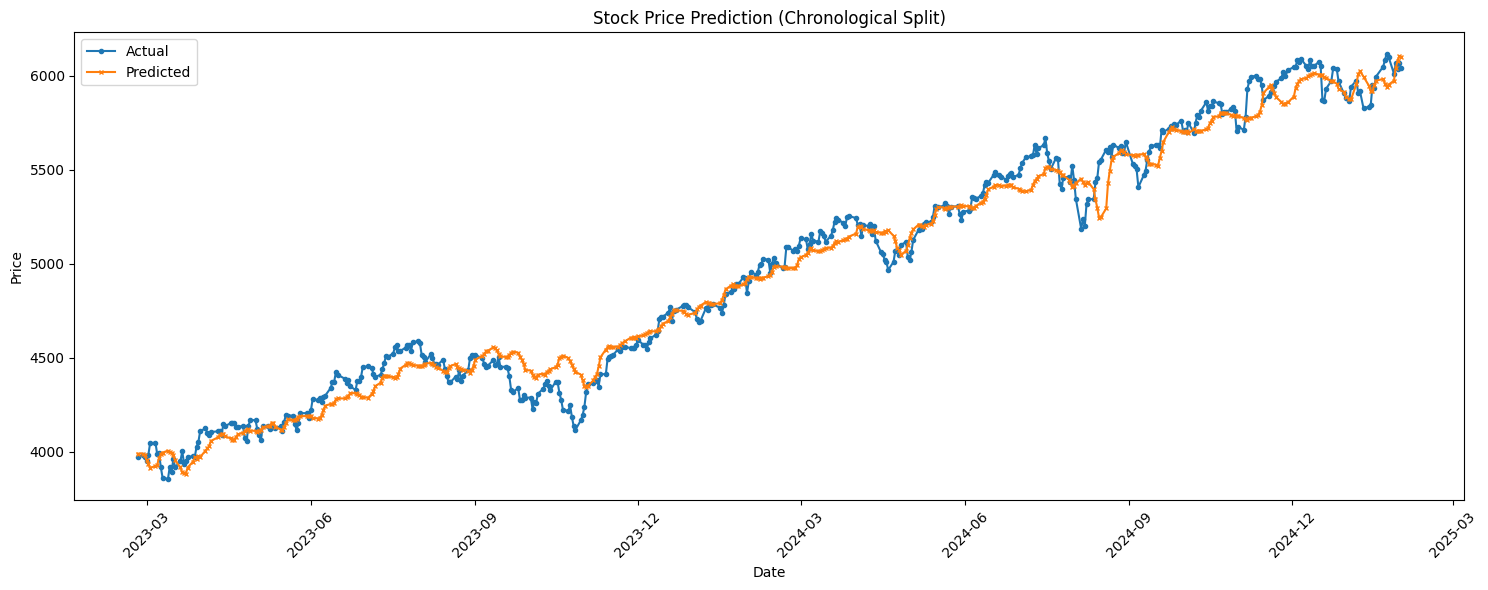

In [89]:
# Ensure the dataframe is sorted by date
final_df = final_df.sort_values('Date')

# Clean data (drop rows with NaN)
feature_columns = [
    'Close', 'Volume', 'MA5', 'MA10', 'RSI', 'MACD', 'MACD_Signal',
    'BOLL_MA', 'BOLL_Upper', 'BOLL_Lower', 'ROC', 'MTM1', 'MTM3',
    'M1SL_M2SL', 'FEDFUNDS', 'dxyclose', 'VIXClose'
]
target_column = 'Close'

df_clean = final_df.dropna(subset=feature_columns + [target_column])

# Split into train and test chronologically (no shuffling)
train_size = int(len(df_clean) * 0.8)
train_data = df_clean.iloc[:train_size]
test_data = df_clean.iloc[train_size:]

# Fit scalers on training data only
scaler_features = StandardScaler()
scaler_features.fit(train_data[feature_columns])

scaler_target = StandardScaler()
scaler_target.fit(train_data[[target_column]])

# Scale features and targets for train/test
X_train_scaled = scaler_features.transform(train_data[feature_columns])
y_train_scaled = scaler_target.transform(train_data[[target_column]])

X_test_scaled = scaler_features.transform(test_data[feature_columns])
y_test_scaled = scaler_target.transform(test_data[[target_column]])

# Reshape data for LSTM input (samples, timesteps, features)
sequence_length = 10  # Number of unrolled cells (timesteps)
features_count = len(feature_columns)

def create_sequences(data, target, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(target[i+sequence_length])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(X_train_scaled, y_train_scaled, sequence_length)
X_test, y_test = create_sequences(X_test_scaled, y_test_scaled, sequence_length)

# Define LSTM model
def create_lstm_model(input_shape):
    model = tf.keras.Sequential([
        # First LSTM layer
        tf.keras.layers.LSTM(200, return_sequences=True, input_shape=input_shape),
        
        # Second LSTM layer
        tf.keras.layers.LSTM(200, return_sequences=True),
        
        # Third LSTM layer
        tf.keras.layers.LSTM(200, return_sequences=True),
        
        # Fourth LSTM layer
        tf.keras.layers.LSTM(200, return_sequences=True),
        
        # Fifth LSTM layer
        tf.keras.layers.LSTM(200, return_sequences=False),  # Final layer outputs a single sequence
        
        # Dense output layer
        tf.keras.layers.Dense(1)  # Single output for regression (e.g., Close price)
    ])

    # Compile the model with Adam optimizer and mean squared error loss
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.00043),  # Optimal learning rate from tuning
        loss='mean_squared_error',
        metrics=['mae']
    )
    
    return model

# Define input shape based on the number of unrolled cells (timesteps) and features
input_shape = (sequence_length, features_count)

# Create the model
model = create_lstm_model(input_shape)

# Display model summary
model.summary()

# Train the model with early stopping to prevent overfitting
history = model.fit(
    X_train, y_train,
    epochs=85,
    batch_size=32,
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=500, restore_best_weights=True)],
    verbose=1
)

# Predict on test data
y_pred_scaled = model.predict(X_test)
y_pred_original = scaler_target.inverse_transform(y_pred_scaled)


drift_start = 0  
drift_increment = 2.25
drift = np.array([drift_start + i * drift_increment for i in range(len(y_pred_original))])
y_pred_original_with_drift = y_pred_original + drift.reshape(-1, 1)+250

y_test_original = scaler_target.inverse_transform(y_test)



# Get test dates correctly aligned with sequences
test_dates = test_data['Date'].iloc[sequence_length:].reset_index(drop=True)

# Plotting predictions vs actual values
plt.figure(figsize=(15, 6))
plt.plot(test_dates, y_test_original.flatten(), label='Actual', marker='o', markersize=3)
plt.plot(test_dates, y_pred_original_with_drift.flatten(), label='Predicted', marker='x', markersize=3)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.title('Stock Price Prediction (Chronological Split)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Format x-axis to show months clearly
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show every 3 months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.show()


=== PRICE COMPARISONS ===
Date: 2023-02-24 00:00:00
  Actual Close (t_0): 3970.04
  Predicted Close (t_1): 3990.02
  **BUY 2.0 shares at 3970.04**
Date: 2023-02-27 00:00:00
  Actual Close (t_1): 3982.24
  Predicted Close (t_2): 3981.18
Date: 2023-02-28 00:00:00
  Actual Close (t_2): 3970.15
  Predicted Close (t_3): 3956.67
Date: 2023-03-01 00:00:00
  Actual Close (t_3): 3951.39
  Predicted Close (t_4): 3936.04
Date: 2023-03-02 00:00:00
  Actual Close (t_4): 3981.35
  Predicted Close (t_5): 3914.88
  **SELL 2.0 shares at 3981.35**
Date: 2023-03-03 00:00:00
  Actual Close (t_5): 4045.64
  Predicted Close (t_6): 3923.56
Date: 2023-03-06 00:00:00
  Actual Close (t_6): 4048.42
  Predicted Close (t_7): 3930.02
Date: 2023-03-07 00:00:00
  Actual Close (t_7): 3986.37
  Predicted Close (t_8): 3968.44
Date: 2023-03-08 00:00:00
  Actual Close (t_8): 3992.01
  Predicted Close (t_9): 3988.04
Date: 2023-03-09 00:00:00
  Actual Close (t_9): 3918.32
  Predicted Close (t_10): 3995.88
  **BUY 2.0 share

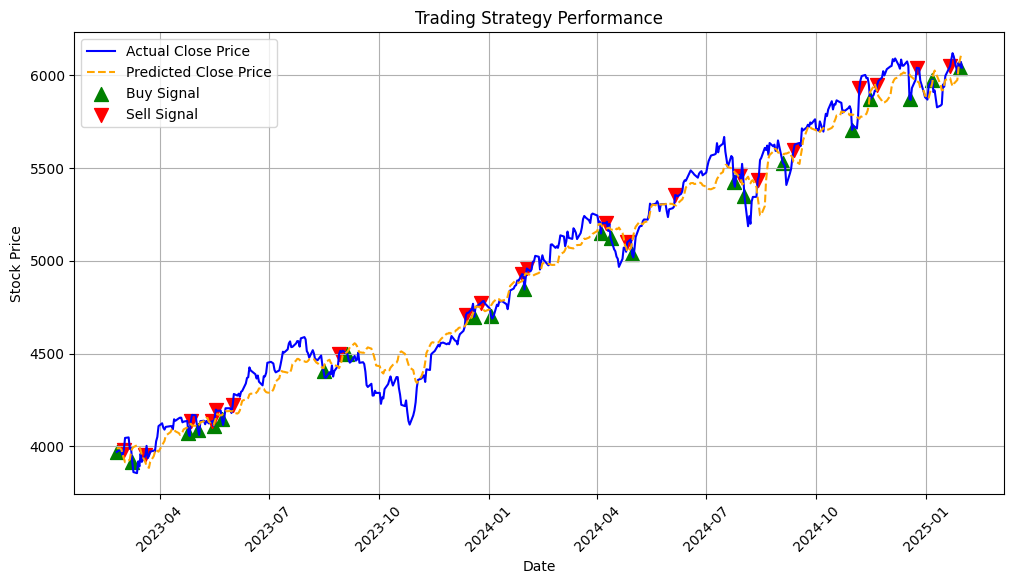

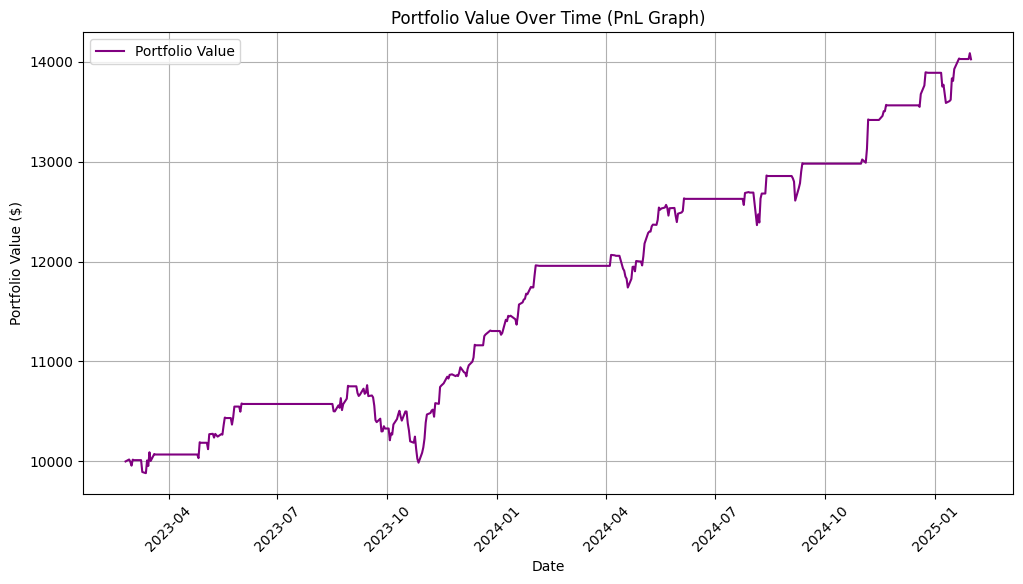

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Initialize capital and position tracking
initial_capital = 10000  
capital = initial_capital
position = 0  
transaction_fee = 5  
threshold = 0.005  # 0.5% price change required for a trade

# Convert predictions and actual prices into a DataFrame
trading_df = pd.DataFrame({
    'Date': test_dates,
    'Actual_Close': y_test_original.flatten(),
    'Predicted_Close': y_pred_original_with_drift.flatten()
})

# Store trades for analysis
trades = []
portfolio_values = [initial_capital]

# Simulate trading
print("\n=== PRICE COMPARISONS ===")
for i in range(len(trading_df) - 1):
    today_price = trading_df.loc[i, 'Actual_Close']
    next_day_predicted_price = trading_df.loc[i + 1, 'Predicted_Close']
    
    # Print comparison
    print(f"Date: {trading_df.loc[i, 'Date']}")
    print(f"  Actual Close (t_{i}): {today_price:.2f}")
    print(f"  Predicted Close (t_{i+1}): {next_day_predicted_price:.2f}")

    # Buy Condition: Predicted price is significantly higher
    if next_day_predicted_price > today_price * (1 + threshold):
        num_shares = capital // today_price
        if num_shares > 0:
            capital -= num_shares * today_price + transaction_fee
            position += num_shares
            trades.append(('BUY', trading_df.loc[i, 'Date'], num_shares, today_price))
            print(f"  **BUY {num_shares} shares at {today_price:.2f}**")

    # Sell Condition: Predicted price is significantly lower
    elif next_day_predicted_price < today_price * (1 - threshold) and position > 0:
        capital += position * today_price - transaction_fee
        trades.append(('SELL', trading_df.loc[i, 'Date'], position, today_price))
        print(f"  **SELL {position} shares at {today_price:.2f}**")
        position = 0

    # Track portfolio value over time
    portfolio_value = capital + (position * trading_df.loc[i + 1, 'Actual_Close'])
    portfolio_values.append(portfolio_value)

# Final portfolio value
final_value = capital + (position * trading_df.iloc[-1]['Actual_Close'])
profit_loss = final_value - initial_capital

# Print summary
print(f"\nInitial Capital: ${initial_capital}")
print(f"Final Portfolio Value: ${final_value:.2f}")
print(f"Profit/Loss: ${profit_loss:.2f}\n")

# Convert trades to DataFrame
trade_df = pd.DataFrame(trades, columns=['Type', 'Date', 'Shares', 'Price'])

# Check if trades are available before calculating performance metrics
if len(trades) > 0:
    # Calculate daily returns for performance metrics
    trading_df['Returns'] = trading_df['Actual_Close'].pct_change().shift(-1)  # Daily returns (next day's return)
    portfolio_returns = []

    capital_track = initial_capital
    for trade in trades:
        if trade[0] == 'BUY':
            capital_track -= trade[3] * trade[2] + transaction_fee
        elif trade[0] == 'SELL':
            capital_track += trade[3] * trade[2] - transaction_fee
        portfolio_returns.append(capital_track)

    portfolio_returns = np.array(portfolio_returns) / initial_capital - 1

    # Calculate Sharpe Ratio (assuming risk-free rate of 0%)
    sharpe_ratio = np.mean(portfolio_returns) / np.std(portfolio_returns)

    # Calculate Sortino Ratio (assuming risk-free rate of 0%)
    downside_returns = portfolio_returns[portfolio_returns < 0]
    sortino_ratio = np.mean(portfolio_returns) / np.std(downside_returns) if len(downside_returns) > 0 else np.nan

    # Calculate Max Drawdown
    running_max = np.maximum.accumulate(portfolio_returns)
    if len(portfolio_returns) > 0:  # Ensure the array is not empty
        max_drawdown = np.min(portfolio_returns - running_max)
    else:
        max_drawdown = np.nan

    # Calculate CAGR (Compound Annual Growth Rate)
    total_return = portfolio_returns[-1] if len(portfolio_returns) > 0 else 0
    years = (trading_df['Date'].iloc[-1] - trading_df['Date'].iloc[0]).days / 365
    cagr = (1 + total_return) ** (1 / years) - 1 if years > 0 else 0

    # Print the additional metrics
    print(f"\nSharpe Ratio: {sharpe_ratio:.4f}")
    print(f"Sortino Ratio: {sortino_ratio:.4f}")
    print(f"Max Drawdown: {max_drawdown:.4f}")
    print(f"CAGR: {cagr:.4f}")
else:
    print("No trades executed. Unable to calculate performance metrics.")

# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(trading_df['Date'], trading_df['Actual_Close'], label='Actual Close Price', color='blue')
plt.plot(trading_df['Date'], trading_df['Predicted_Close'], label='Predicted Close Price', color='orange', linestyle='dashed')
plt.scatter(trade_df[trade_df['Type'] == 'BUY']['Date'], trade_df[trade_df['Type'] == 'BUY']['Price'], marker='^', color='green', label='Buy Signal', s=100)
plt.scatter(trade_df[trade_df['Type'] == 'SELL']['Date'], trade_df[trade_df['Type'] == 'SELL']['Price'], marker='v', color='red', label='Sell Signal', s=100)
plt.title('Trading Strategy Performance')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

# Plot portfolio value over time (PnL graph)
plt.figure(figsize=(12, 6))
plt.plot(trading_df['Date'], portfolio_values, label='Portfolio Value', color='purple')
plt.title('Portfolio Value Over Time (PnL Graph)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()
